# UN Analysis

Analysis of UN actors in agreement-actor networks.


In [1]:
__author__      = 'Roy Gardner'

%run ./network_functions.py


## Load the agreement-actor data

- Load data into a binary-valued relation matrix (BVRM) with agreements in rows and actors in columns
- Matrix values are zero except where a relation between an agreement and an actor exists where the value is one
- Apart from the matrix other data are extracted or computed
- All data are stored in data_dict


In [2]:

data_path = './data/'
nodes_file = 'node_table.csv'
links_file = 'links_table.csv'
agreements_dict = 'agreements_dict.json'

data_dict = load_agreement_actor_data(nodes_file,links_file,agreements_dict,data_path)
print(data_dict.keys())


dict_keys(['agreements_dict', 'dates_dict', 'nodes_data', 'nodes_header', 'links_data', 'links_header', 'agreement_vertices', 'actor_vertices', 'vertices_dict', 'color_map', 'matrix'])


## Collect UN actor indices and IDs

In [3]:

un_actors_list = []

for actor_index,actor_id in enumerate(data_dict['actor_vertices']):
    if len(actor_id) == 0:
        continue
    actor_data = data_dict['vertices_dict'][actor_id]
    actor_name = actor_data[data_dict['nodes_header'].index('node_name')]
    if 'United Nations' in actor_name or 'UN ' in actor_name or ' UN' in actor_name:
        un_actors_list.append((actor_index,actor_id,actor_name))

un_actors_list = sorted(un_actors_list,key=lambda t:t[2])
print(un_actors_list)


[(562, 'COA_51', 'Group of Friends UNSG'), (933, 'IGO_640', 'Office of the United Nations High Commissioner for Human Rights'), (1066, 'IGO_315', 'UN General Assembly'), (871, 'IGO_672', 'UN Office on Drugs and Crimes'), (259, 'IGO_386', 'UN Secretary General'), (440, 'IGO_8', 'UN Security Council'), (1090, 'IGO_49', 'United Nations (General)'), (693, 'IGO_459', "United Nations Children's Fund"), (729, 'IGO_64', 'United Nations Development Programme'), (557, 'IGO_678', 'United Nations Educational, Scientific and Cultural Organization'), (750, 'IGO_440', 'United Nations Human Rights Council'), (960, 'IGO_674', 'United Nations Population Fund'), (448, 'IGO_391', 'United Nations Secretariat')]


## Get UN actor biadjacency matrices

There are two matrices:

1. UN-only matrix: 
    - Rows are agreements that have at least one UN signatory
    - Columns are UN actors
2. UN actors and non-UN co-signatories matrix:
    - Rows are agreements that have at least one UN signatory (as above)
    - Columns are all the actors who are signatories to the row agreements

The indices of the agreements and actors that constitute the above matrices are:

- agreement_indices: Indices into `data_dict['agreement_vertices']` and therefore rows of `data_dict['matrix']`
- un_indices: Indices into `data_dict['actor_vertices']` and therefore columns of `data_dict['matrix']` for UN actors only
- actor_indices: Indices into `data_dict['actor_vertices']` and therefore columns of `data_dict['matrix']` for UN actors and co-signatories


In [8]:
un_indices = [t[0] for t in un_actors_list]

matrix = data_dict['matrix']

# Reduce the matrix to UN actor columns only
reduced_matrix = matrix[np.ix_(range(0,matrix.shape[0]),un_indices)]
# Get indices of agreement row containing at least one non-zero value, i.e., agreements signed by at least
# one of the UN actors
indices = np.nonzero(reduced_matrix)
agreement_indices = list(set(indices[0]))

# This is the UN actors only matrix
un_matrix = matrix[np.ix_(agreement_indices,un_indices)]
print(un_matrix.shape)


# Reduce the complete matrix to the UN agreement rows and all actors
reduced_matrix = matrix[np.ix_(agreement_indices,range(0,matrix.shape[1]))]

# Get indices of all non-zero actor columns for the agreement rows, i.e., UN actors and co-signatories
indices = np.nonzero(reduced_matrix)
actor_indices = list(set(indices[1]))

# This is the UN actors and non-UN co-signatories matrix
un_cosign_matrix = reduced_matrix[np.ix_(range(0,len(agreement_indices)),actor_indices)]
print(un_cosign_matrix.shape)
print()

print('There are',un_matrix.shape[0],'agreements signed by at least one of',un_matrix.shape[1],\
      'UN actors, and one or more of',un_cosign_matrix.shape[1] - un_matrix.shape[1],'non-UN actors')

(314, 13)
(314, 517)

There are 314 agreements signed by at least one of 13 UN actors, and one or more of 504 non-UN actors


### Visualisations: UN-only

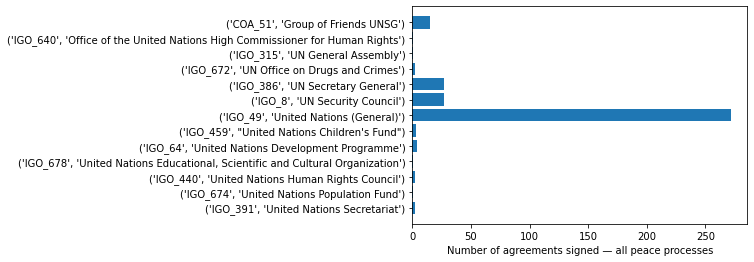

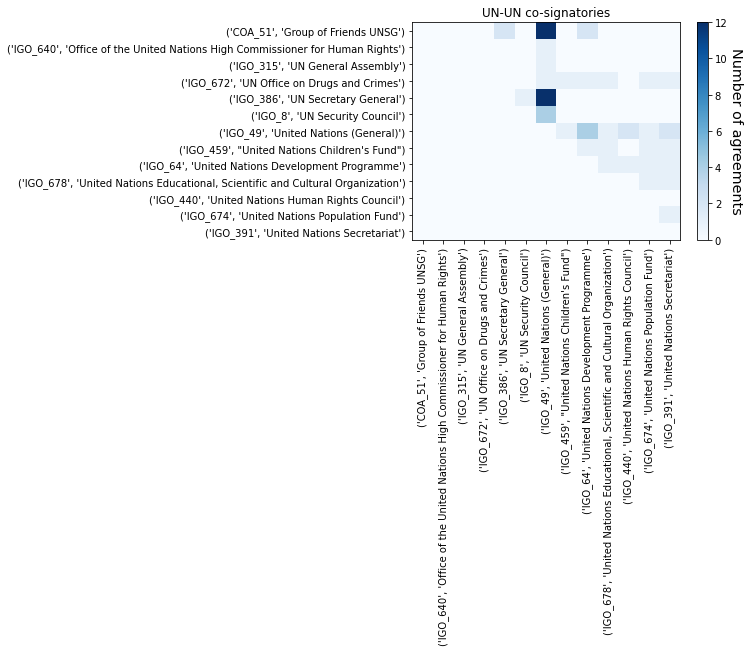

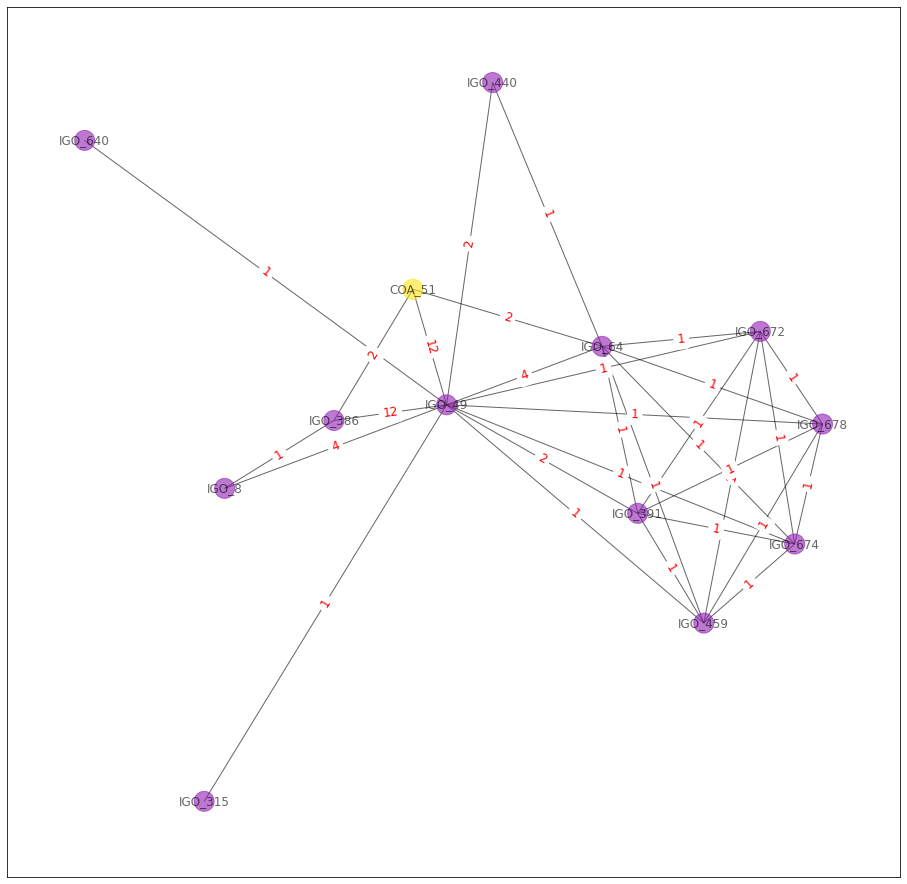

('Group of Friends UNSG', 'United Nations (General)', 12)
('UN Secretary General', 'United Nations (General)', 12)
('UN Security Council', 'United Nations (General)', 4)
('United Nations (General)', 'United Nations Development Programme', 4)
('Group of Friends UNSG', 'UN Secretary General', 2)
('Group of Friends UNSG', 'United Nations Development Programme', 2)
('United Nations (General)', 'United Nations Human Rights Council', 2)
('United Nations (General)', 'United Nations Secretariat', 2)
('Office of the United Nations High Commissioner for Human Rights', 'United Nations (General)', 1)
('UN General Assembly', 'United Nations (General)', 1)
('UN Office on Drugs and Crimes', 'United Nations (General)', 1)
('UN Office on Drugs and Crimes', "United Nations Children's Fund", 1)
('UN Office on Drugs and Crimes', 'United Nations Development Programme', 1)
('UN Office on Drugs and Crimes', 'United Nations Educational, Scientific and Cultural Organization', 1)
('UN Office on Drugs and Crimes

In [16]:
# Get UN actor labels

label_list = [(t[1],t[2]) for t in un_actors_list]

co_matrices = get_cooccurrence_matrices(un_matrix)


# Co-occurrence diagonal is the columns marginal of the UN-only matrix

diag = np.diag(co_matrices[0])

plt.barh(range(0,len(diag)),diag)
plt.yticks(range(0,len(label_list)),label_list)
plt.xlabel('Number of agreements signed — all peace processes')
plt.gca().invert_yaxis()
plt.show()

# Upper triangle of actor co-occurence matrix
actor_upper = np.triu(co_matrices[0],k=1)

plt.imshow(actor_upper,aspect='auto',cmap=plt.cm.Blues)
plt.xticks(range(0,len(label_list)),label_list,rotation=90)
plt.yticks(range(0,len(label_list)),label_list)
cbar = plt.colorbar()
cbar.set_label('Number of agreements',rotation=270,labelpad=15,fontsize='x-large')
plt.title('UN-UN co-signatories')
plt.show()

display_comatrix_as_networkx_graph(co_matrices[0],un_indices,data_dict['actor_vertices'],data_dict)

rc = np.nonzero(actor_upper) # Row and column indices of non-zero pairs
z = list(zip(list(rc[0]),list(rc[1])))
scores = [(un_actors_list[t[0]][2],un_actors_list[t[1]][2],actor_upper[t[0]][t[1]]) for t in z]
scores = sorted(scores,key=lambda t:t[2],reverse=True)
for t in scores:
    print(t)


### Visualisation: UN and non-UN co-signatories

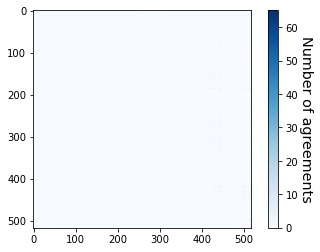

In [6]:
co_matrices = get_cooccurrence_matrices(un_cosign_matrix)
actor_upper = np.triu(co_matrices[0],k=1)

plt.imshow(actor_upper,cmap=plt.cm.Blues)
cbar = plt.colorbar()
cbar.set_label('Number of agreements',rotation=270,labelpad=15,fontsize='x-large')
plt.show()
